In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

In [62]:
srcdir = "../../../data/eval/airlinecrm/230808/"
metric = 'success'

In [ ]:
dfs = []

for filename in os.listdir(srcdir):
    if filename.endswith(".csv"):
        filepath = os.path.join(srcdir, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

df_file = pd.concat(dfs, ignore_index=True)
df = df_file

print(len(df))
df.head(5)

In [64]:
df_group = df.groupby(['task', 'scenario', 'policy'])

max_metric = df_group[metric].max()
df = df_group.first().reset_index()
df[metric] = max_metric.values

print(len(df))

221


In [65]:
# Tasks
tasks = [
	'TASK_CANCEL_FLIGHT',
    'TASK_FIND_BOOKING',
    'TASK_FIND_FLIGHT',
    'TASK_UPDATE_PASSENGER_DETAILS',
    'TASK_BOOK_FLIGHT',
]

In [ ]:
metrics = ['success', 'task_progress', 'num_actions']
policies = ['flat_zeroshot', 'flat_fewshot', 'paw_zeroshot', 'paw_fewshot']
mean_table = pd.DataFrame()
error_table = pd.DataFrame()
max_seed = 20
# loop over all metrics and print each table
for metric in metrics:
    zero_offset = 0.01

    df_sub = df[df['policy'].isin(policies)] if policies is not None else df
    df_sub = df_sub[df_sub['task'].isin(tasks)] if tasks is not None else df_sub

    # Group the filtered DataFrame by 'policy' and 'task' and calculate the average metric
    df_group = df_sub.groupby(['policy', 'task'])[metric].mean().reset_index()
    pivot_table = df_group.pivot(index='task', columns='policy', values=metric)
    pivot_table[pivot_table == 0] = zero_offset
    pivot_table = (pivot_table * max_seed).astype(int) / max_seed

    df_group_se = df_sub.groupby(['policy', 'task'])[metric].sem().reset_index()
    pivot_table_se = df_group_se.pivot(index='task', columns='policy', values=metric)
    pivot_table_se = (pivot_table_se * max_seed).astype(int) / max_seed
    
    # Rename the columns to include the metric
    pivot_table.columns = [f'{col}_{metric}' for col in pivot_table.columns]

    if mean_table.empty:
        mean_table = pivot_table
    else:
        mean_table = pd.concat([mean_table, pivot_table], axis=1)

    # Rename the columns to include the metric
    pivot_table_se.columns = [f'{col}_{metric}' for col in pivot_table_se.columns]
    
    if error_table.empty:
        error_table = pivot_table_se
    else:
        error_table = pd.concat([error_table, pivot_table_se], axis=1)

    # Reorder the columns to match the order in the policies list
    #pivot_table = pivot_table[policies]

    # Print table in a pretty format
    print("\nMetric: ", metric)
    print(pivot_table.to_string())
    
mean_table = mean_table.reindex(tasks)

In [ ]:
# Creating a DataFrame to hold the combined values
combined_table = mean_table.copy()
combined_table = combined_table[['flat_zeroshot_success', 'flat_fewshot_success', 'paw_fewshot_success', 'paw_fewshot_num_actions']]

# Iterate through the columns and rows to create the "mean ± error" strings
columns_to_include = combined_table.columns
for col in columns_to_include:
    combined_table[col] = mean_table[col].map("{:.2f}".format) + " ± " + error_table[col].map("{:.2f}".format)

# Resetting the index to include it in the Markdown output
combined_table.reset_index(inplace=True)

# Converting to Markdown and printing
markdown_table = combined_table.to_markdown(index=False)
print(markdown_table)

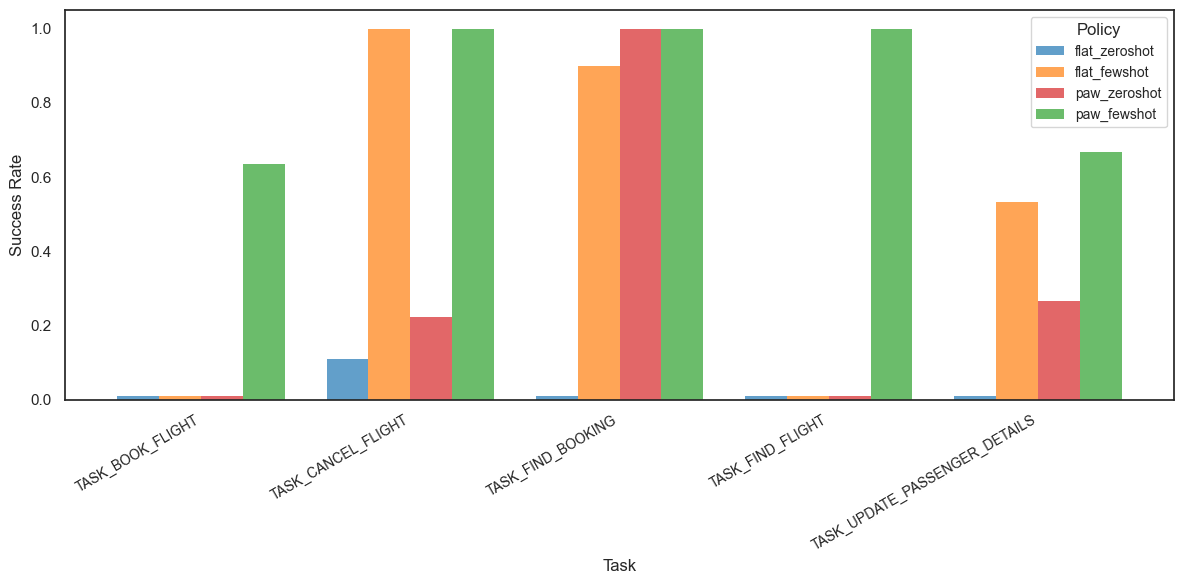

In [68]:
metrics = ['success', 'task_progress', 'num_actions']
policies = ['flat_zeroshot', 'flat_fewshot', 'paw_zeroshot', 'paw_fewshot']

metric = metrics[0]
zero_offset = 0.01

df_sub = df[df['policy'].isin(policies)] if policies is not None else df
df_sub = df_sub[df_sub['task'].isin(tasks)] if tasks is not None else df_sub

# Group the filtered DataFrame by 'policy' and 'task' and calculate the average metric
df_group = df_sub.groupby(['policy', 'task'])[metric].mean().reset_index()
pivot_table = df_group.pivot(index='task', columns='policy', values=metric)
pivot_table[pivot_table == 0] = zero_offset
pivot_table = pivot_table[policies]

sns.set(style='white')
colors = sns.color_palette('tab10', n_colors=len(pivot_table.columns))
colors = [color + (0.7,) for color in colors]
colors[2], colors[3] = colors[3], colors[2]

fig, ax = plt.subplots(figsize=(12, 6))

pivot_table.plot(kind='bar', ax=ax, color=colors, edgecolor='none', width=0.8)

labels = {'success': 'Success Rate', 'num_actions': 'Number of Actions'}
ax.set_xlabel('Task', fontsize=12)
ax.set_ylabel(labels[metric], fontsize=12)
# ax.set_ylim(0, 1)
ax.set_xticklabels(pivot_table.index, rotation=30, ha='right', fontsize=10)

plt.legend(title='Policy', fontsize=10)
# plt.title(f'{metric}', fontsize=14)

# Remove the grid
ax.grid(False)

plt.tight_layout()
plt.show()


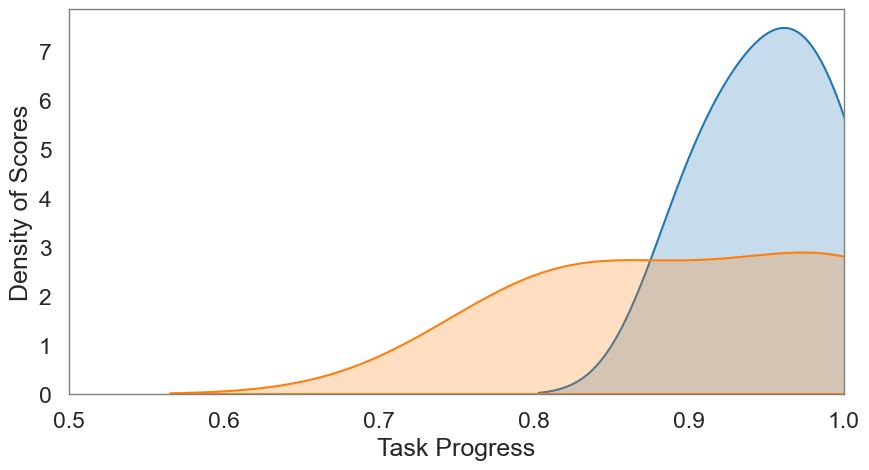

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 36})
sns.set_context("talk")  # can be 'paper', 'notebook', 'talk', 'poster'

train_tasks = ["TASK_CANCEL_FLIGHT"]
test_tasks = ['TASK_BOOK_FLIGHT', 'TASK_FIND_BOOKING','TASK_FIND_FLIGHT', 'TASK_UPDATE_PASSENGER_DETAILS']
train_df = mean_table[mean_table.index.isin(train_tasks)]
test_df = mean_table[mean_table.index.isin(test_tasks)]

# Setting up the seaborn style
sns.set_style("white")

# Plotting the KDE for both columns
sns.kdeplot(pd.concat([train_df['paw_fewshot_task_progress'], pd.Series([0.97, 0.94, 0.9])]), fill=True, label='Train Task Progress', color='#1f77b4')
sns.kdeplot(test_df['paw_fewshot_task_progress'], fill=True, label='Test Task Progress', color='#ff7f0e')

# Adjusting the spines
for spine in plt.gca().spines.values():
    spine.set_edgecolor('gray')  # You can change 'lightgray' to any other color
    spine.set_linewidth(1)  

# Titles and labels
# plt.title('Density Plot of Train vs Test Task Progress')
plt.xlabel('Task Progress')
plt.ylabel('Density of Scores')
plt.xlim(0.5, 1)  # Limiting the x-axis range
# plt.legend(loc='upper left')  # Moved the legend to the top left

plt.show()